In [1]:
# this lesson represents leah's working through processing the real landsat data (not cropped)

import rasterio as rio
import geopandas as gpd
import earthpy as et
import os
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
import matplotlib.pyplot as plt
from rasterio.plot import show
from glob import glob
import numpy as np
import numpy.ma as ma
import seaborn as sns
plt.ion()
from skimage import data, img_as_float
from skimage import exposure
from rasterio.mask import mask
from shapely.geometry import mapping
import fiona


from scipy.misc import bytescale
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20

First process the cloud free data. Note that the spatial extent is larger than the other data!

In [ ]:
all_landsat_bands_pre = glob("data/week_07/landsat/LC80340322016173-SC20170227185411/*band*.tif")
all_landsat_bands_pre = [rio.open(ifile) for ifile in all_landsat_bands_pre]
#all_landsat_bands_pre

In [3]:
# when you set masked = True it doesn't seem to work
# it's still showing the -9999
all_landsat_bands_pre_data = np.array([ifile.read()[0] for ifile in all_landsat_bands_pre])
all_landsat_bands_pre_data[1]
all_landsat_bands_pre_data.shape

(7, 7931, 7791)

In [4]:
# this creates a 7 band numpy array - as we would expect
print(all_landsat_bands_pre_data.shape)
all_landsat_bands_pre[1].profile

(7, 7931, 7791)


{'affine': Affine(30.0, 0.0, 318585.0,
       0.0, -30.0, 4583415.0),
 'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'int16',
 'height': 7931,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': False,
 'transform': (318585.0, 30.0, 0.0, 4583415.0, 0.0, -30.0),
 'width': 7791}

In [5]:
all_landsat_bands_pre[1].nodatavals

(-9999.0,)

In [6]:
type(all_landsat_bands_pre_data)

numpy.ndarray

In [7]:

# assign any value smaller than 0 to mask = TRUE
all_landsat_bands_pre_data = ma.masked_where(all_landsat_bands_pre_data < -2000, all_landsat_bands_pre_data)

all_landsat_bands_pre_data[3]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=int16)

In [8]:
#all_landsat_bands_pre.read(masked=True)
print(all_landsat_bands_pre_data[1].ravel().max())
print(all_landsat_bands_pre_data[1].ravel().min())

9853
-169


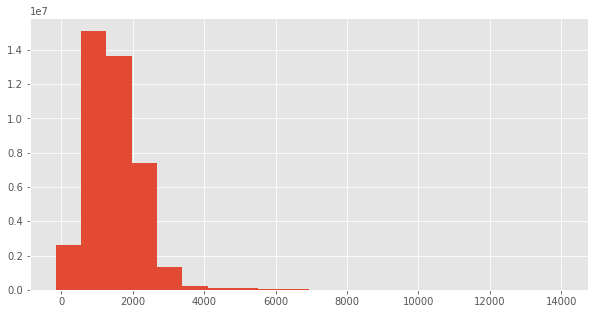

In [9]:
# Why does plt.hist work but ax.hist doesn't work
fig, axs = plt.subplots(figsize=(10, 5))
plt.hist(all_landsat_bands_pre_data[6].ravel(), bins=20);

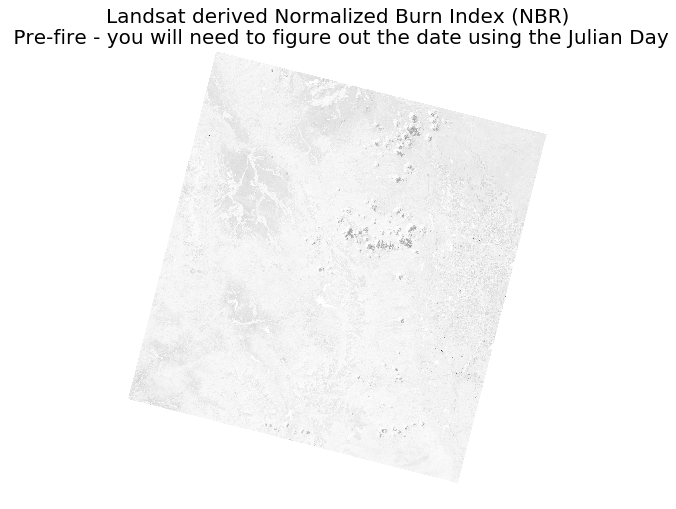

In [10]:
# note the data are not yet cropped but you can see the data seem generally ok
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(all_landsat_bands_pre_data[6], cmap='Greys')
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Pre-fire - you will need to figure out the date using the Julian Day")
ax.set_axis_off();

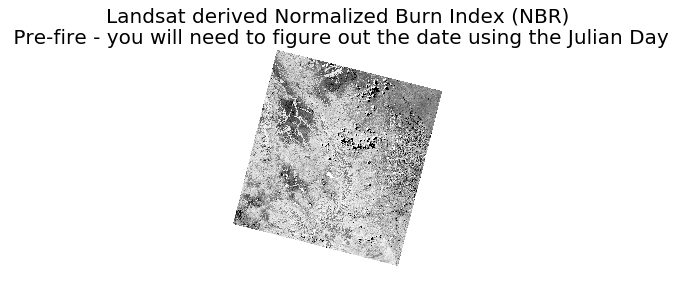

In [11]:
# apply contrast stretch vmin=0, vmax=2
# note the data are not yet cropped but you can see the data seem generally ok
fig, ax = plt.subplots()
ax.imshow(all_landsat_bands_pre_data[6], cmap='Greys', vmin=0, vmax=3500)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Pre-fire - you will need to figure out the date using the Julian Day")
ax.set_axis_off();

In [12]:
all_landsat_bands_pre[1].bounds


BoundingBox(left=318585.0, bottom=4345485.0, right=552315.0, top=4583415.0)

In [13]:
# get the clip extent from the clipped raster
all_landsat_bands_pre_cloud = glob("data/week_07/landsat/LC80340322016189-SC20170128091153/crop/*band*.tif")
all_landsat_bands_pre_cloud = [rio.open(ifile) for ifile in all_landsat_bands_pre_cloud]

landsat_band5 = all_landsat_bands_pre_cloud[4]

bounds = landsat_band5.bounds
bounds

landsat_bounds = all_landsat_bands_pre[1].bounds
landsat_bounds
#left, right, bottom, top
landsat_ext = [landsat_bounds[0], landsat_bounds[2], landsat_bounds[1], landsat_bounds[3]]

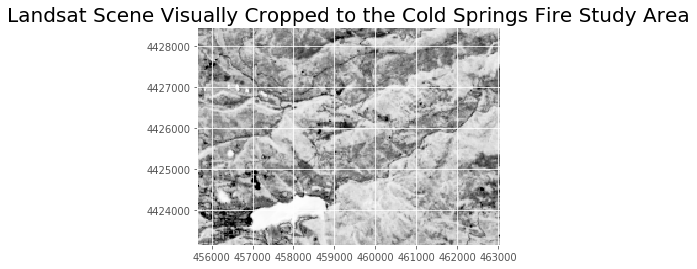

In [14]:
# let's plot the data but zoomed in on the study area
# Note that .bounds doesn't provide the extent in the right order
# it needs to be: left, right, bottom, top

# is there a way to adjust the z limits to stretch this image some?
fig, ax = plt.subplots()
ax.imshow(all_landsat_bands_pre_data[6], cmap='Greys', extent=landsat_ext, vmin=0, vmax=2500)
ax.set(xlim=[bounds[0], bounds[2]], ylim=[bounds[1], bounds[3]])
ax.set_title("Landsat Scene Visually Cropped to the Cold Springs Fire Study Area");

In [15]:
type(all_landsat_bands_pre_data[4])

numpy.ma.core.MaskedArray

In [16]:
all_landsat_bands_pre_data.shape
#all_landsat_bands_pre[2]

(7, 7931, 7791)

In [17]:
all_landsat_bands_pre_data[4]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=int16)

In [18]:
# Plot RGB data -- this likely requires a stretch 
# but also check that i'm using the right bands
# how do we apply a mask here with matplotlib? -- 
# here the mask is lost
plot_indices = [3, 2, 1]
rgb_data = []
for ix in plot_indices:
    rgb_data.append(all_landsat_bands_pre_data[ix])  
    
# transpose the data to make matplotlib happy    
rgb_data = np.ma.array(rgb_data).transpose([1, 2, 0])
type(rgb_data)

numpy.ma.core.MaskedArray

/Users/lewa8222/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  app.launch_new_instance()


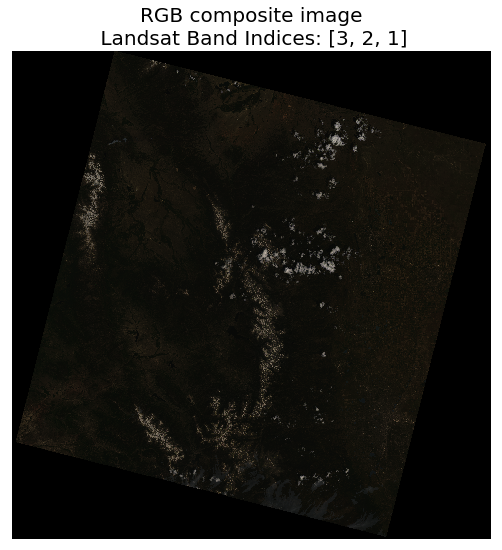

In [19]:
# plot 
fig, ax = plt.subplots(figsize = (9,9))
ax.imshow(bytescale(rgb_data))
ax.set(title="RGB composite image\n Landsat Band Indices: {}".format(plot_indices))
ax.set(xticks=[], yticks=[]);

In [20]:
# the stretch below clips at the 2nd and 98th percentile
rgb_data_stretch = []
for i in range(rgb_data.shape[2]):
    band = rgb_data[:,:,i]
    #print(band.shape)
    p2, p98 = np.percentile(band, (2, 98))
    img_rescale = exposure.rescale_intensity(band, in_range=(p2, p98))
    rgb_data_stretch.append(img_rescale)
    
# then transpose to plot 
#all_bands = np.array(all_bands).transpose([1, 2, 0])
all_bands = np.ma.array(rgb_data_stretch).transpose([1, 2, 0])

In [21]:
all_bands.shape
type(all_bands)

numpy.ma.core.MaskedArray

/Users/lewa8222/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


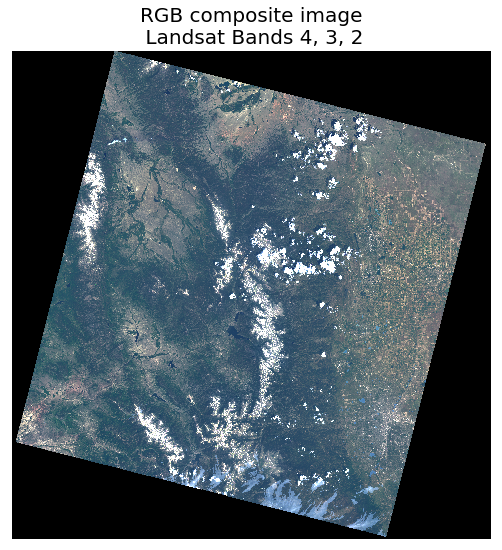

In [22]:
# plot the newly contrast stretched data
# much better! i wonder if we can get rid of the black background?
fig, ax = plt.subplots(figsize = (9,9))
ax.imshow(bytescale(all_bands))
ax.set(title="RGB composite image\n Landsat Bands 4, 3, 2")
ax.set(xticks=[], yticks=[]);

In [23]:
# calculate nbr -- here we perform band math as we would 
landsat_nbr_pre = ((all_landsat_bands_pre_data[4] - all_landsat_bands_pre_data[6]) / (all_landsat_bands_pre_data[4] + all_landsat_bands_pre_data[6]))
# does it produce a masked array? It does. 
landsat_nbr_pre[0]
landsat_nbr_pre.max()

55.0

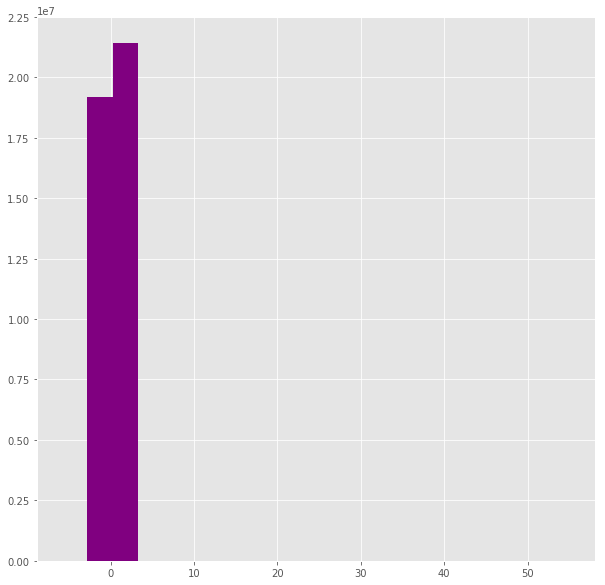

In [24]:
# using plt because ax somehow is stuck
fig, axs = plt.subplots(figsize=(10, 10))
plt.hist(landsat_nbr_pre.ravel(), bins =20, color = "purple")
ax.set_title("Distribution of Pixel Values - NBR Raster");

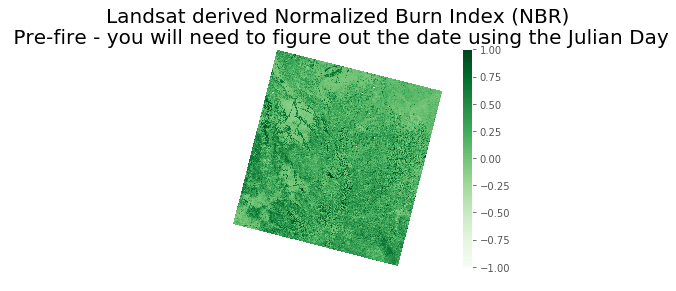

In [25]:
fig, ax = plt.subplots()
nbr = ax.imshow(landsat_nbr_pre, cmap='Greens', vmin=-1, vmax=1)
plt.colorbar(nbr)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Pre-fire - you will need to figure out the date using the Julian Day")
ax.set_axis_off()

In [26]:
# can i copy the attributes from the original data?
#landsat_meta = all_landsat_bands_pre[1].meta
kwargs = all_landsat_bands_pre[1].meta.copy()
kwargs.update({
        'dtype': "float64"})
kwargs

{'affine': Affine(30.0, 0.0, 318585.0,
       0.0, -30.0, 4583415.0),
 'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 7931,
 'nodata': -9999.0,
 'transform': (318585.0, 30.0, 0.0, 4583415.0, 0.0, -30.0),
 'width': 7791}

In [27]:

# this is a aresonable range of values
print(landsat_nbr_pre.min())
print(landsat_nbr_pre.max())
landsat_nbr_pre.dtype
#landsat_nbr[np.isnan(landsat_nbr)] = 0
landsat_nbr_pre[np.isnan(landsat_nbr_pre)] = -9999

-5.857142857142857
55.0


In [28]:
nbr_path_landsat_full = "data/cold-springs-fire/outputs/landsat_nbr_pre.tif"
# write the NBR output -- Here we manually add each attribute
with rio.open(nbr_path_landsat_full, 'w', **kwargs) as dst:
    dst.write(landsat_nbr_pre.astype(np.float64), 1)

/Users/lewa8222/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [29]:
# import the data -- why is this reading in as a value outside of the range of the actual tif values?
with rio.open(nbr_path_landsat_full) as src:
    nbr_full = src.read()
  
# this doesn't work - the max values is still too big
nbr_full2 = ma.masked_where(nbr_full < -1, nbr_full)
nbr_full2 = ma.masked_where(nbr_full2 > 1, nbr_full2)
print(nbr_full2.min())
print(nbr_full2.max()) 
print(nbr_full2.dtype)


-1.0
1.0
float64


Text(0.5,1,'Distribution of Pixel Values - NBR Raster')

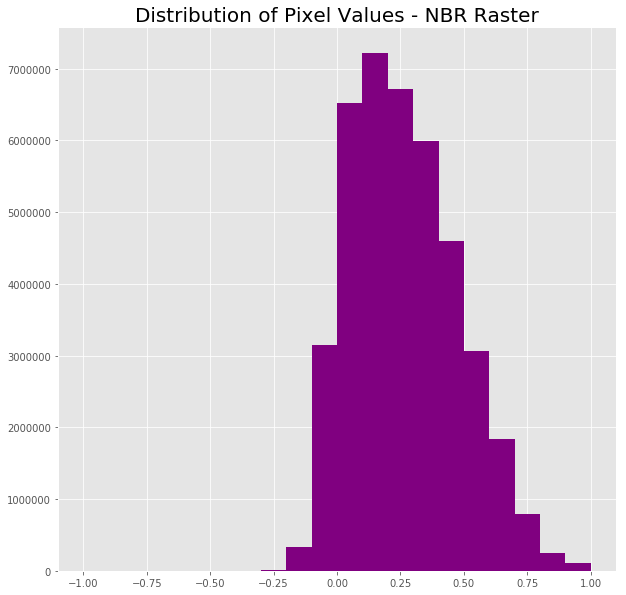

In [30]:
# using plt because ax somehow is stuck
fig, axs = plt.subplots(figsize=(10, 10))
plt.hist(nbr_full2.ravel(), bins =20, color = "purple")
axs.set_title("Distribution of Pixel Values - NBR Raster")
#axs.set_xlim([-1, 1]);

In [31]:
# this is example code that shows how to create a json object that can then be used to clip a raster
# is there another way to clip?
# this doesn't work: error: 'MaskedArray' object has no attribute 'nodata'

# crop the data 
# first import the crop layer
#crop_extent = gpd.read_file('data/cold-springs-fire/vector_layers/fire_crop_box_2000m.shp')

# the code below is grabbing a vector extent to use...
#extent_geojson = mapping(crop_extent['geometry'][0])
#extent_geojson

# import the raster that is not cropped
nbr_not_cropped = rio.open(nbr_path_landsat_full)
nbr_not_cropped.profile
#print(nbr_not_cropped.bounds)
#nbr_not_cropped.dtypes

{'affine': Affine(30.0, 0.0, 318585.0,
       0.0, -30.0, 4583415.0),
 'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 7931,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': False,
 'transform': (318585.0, 30.0, 0.0, 4583415.0, 0.0, -30.0),
 'width': 7791}

In [32]:
# what values are in these data? Something is happening here that is not correct? Although the data are correct
print(nbr_not_cropped.read(masked=True).min())
# what values are in these data?
print(nbr_not_cropped.read(masked=True).max())
#nbr_not_cropped.read().max()

-5.857142857142857
55.0


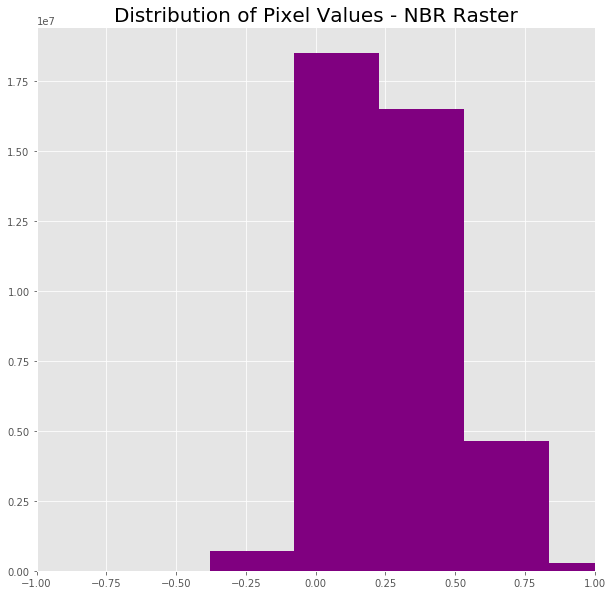

In [33]:
# view hist -- weird axis stuff still happening here... why why why??
# using plt because ax somehow is stuck
fig, axs = plt.subplots(figsize=(10, 10))
plt.hist(nbr_not_cropped.read(masked=True).ravel(), bins =200, color = "purple")
axs.set_title("Distribution of Pixel Values - NBR Raster")
axs.set_xlim([-1, 1]);

In [34]:
#print(geoms)
# note that this geom element has a slightly different json structure... it doesn't work 
#print(extent_geojson)

In [35]:
# open the clip box with fiona and create the geoms feature to mask
# from rasterio.tools.mask import mask
with fiona.open('data/cold-springs-fire/vector_layers/fire_crop_box_2000m.shp', "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

with rio.open(nbr_path_landsat_full) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

clipped_image_path = "data/cold-springs-fire/outputs/nbr_pre_clipped.tif"
with rio.open("data/cold-springs-fire/outputs/nbr_pre_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [36]:
out_meta

{'affine': Affine(30.0, 0.0, 318585.0,
       0.0, -30.0, 4583415.0),
 'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 178,
 'nodata': -9999.0,
 'transform': Affine(30.0, 0.0, 455655.0,
       0.0, -30.0, 4428465.0),
 'width': 247}

In [46]:
# import the data
nbr_pre_clipped_r = rio.open(clipped_image_path)
nbr_pre_clipped = nbr_pre_clipped_r.read(masked=True)
#br_pre_clipped

In [38]:
nbr_pre_clipped.ravel()

masked_array(data=[0.15703275529865124, 0.1487938858371149,
                   0.14877764842840513, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-9999.0)

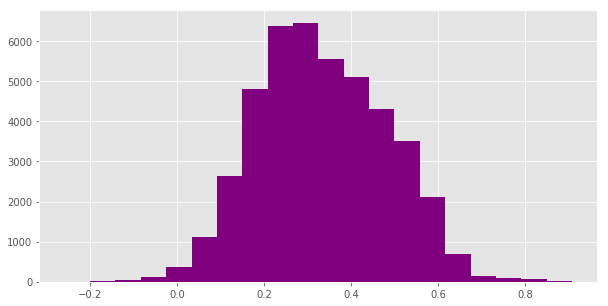

In [39]:
# view histogram of data
fig, axs = plt.subplots(figsize=(10, 5))
plt.hist(nbr_pre_clipped.ravel(), bins=20, color = "purple");

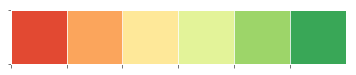

In [40]:

# create a color palette - %%capture will suppreess cell out put
sns.palplot(sns.palettes.color_palette('RdYlGn'))

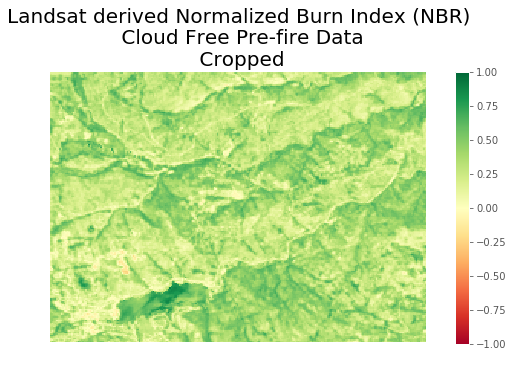

In [41]:
fig, ax = plt.subplots(figsize = (10,5))
nbr_img = ax.imshow(nbr_pre_clipped[0], cmap=plt.cm.get_cmap('RdYlGn', 500), vmin = -1, vmax=1)
plt.colorbar(nbr_img)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Cloud Free Pre-fire Data\n Cropped")
ax.set_axis_off()

In [42]:
#print(extent_geojson)
#type(landsat_nbr_pre)
#landsat_nbr_pre
#ma.set_fill_value(landsat_nbr_pre, -9999.0)
#landsat_nbr_pre
# mask the data
#landsat_nbr_crop, _ = mask(nbr_not_cropped, [extent_geojson], crop=True)
#landsat_nbr_crop.shape
#landsat_nbr_crop[0].shape

Next, process the post fire data

In [43]:
all_landsat_bands_post = glob("data/week_07/landsat/LC80340322016205-SC20170127160728/crop//*band*.tif")
all_landsat_bands_post = [rio.open(ifile) for ifile in all_landsat_bands_post]
# read all of the bands into a np.array format for processing
all_landsat_bands_post_ar = np.array([ifile.read()[0] for ifile in all_landsat_bands_post])
all_landsat_bands_post_ar[1]
all_landsat_bands_post_ar.shape

(7, 177, 246)

In [47]:
# assign any value smaller than -2000 which is the bottom range of valid landsat values to mask = TRUE
all_landsat_bands_post_ar = ma.masked_where(all_landsat_bands_post_ar < -2000, all_landsat_bands_post_ar)
# calculate nbr -- here we perform band math as we would 
landsat_nbr_post = ((all_landsat_bands_post_ar[4] - all_landsat_bands_post_ar[6]) / 
                    (all_landsat_bands_post_ar[4] + all_landsat_bands_post_ar[6]))
#landsat_nbr_post

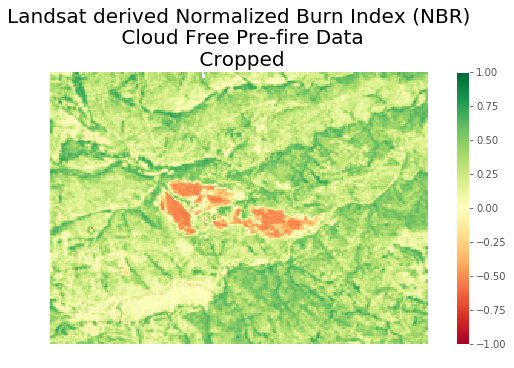

In [50]:
fig, ax = plt.subplots(figsize = (10,5))
dnbr_img = ax.imshow(landsat_nbr_post, cmap=plt.cm.get_cmap('RdYlGn', 500), vmin = -1, vmax=1)
plt.colorbar(dnbr_img)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Cloud Free Pre-fire Data\n Cropped")
ax.set_axis_off()

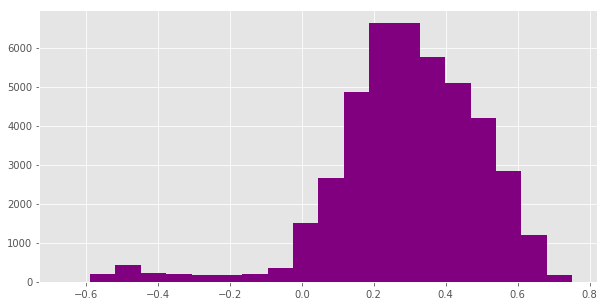

In [51]:
# view histogram of data
fig, axs = plt.subplots(figsize=(10, 5))
plt.hist(landsat_nbr_post.ravel(), bins=20, color = "purple");

In [52]:
print(nbr_pre_clipped[0].shape)
print(landsat_nbr_post.shape)
nbr_pre_clipped[0][:177,:246].shape

(178, 247)
(177, 246)


(177, 246)

NOTE: i need to go back and properly account for the dimension difference in the code.

In [53]:
dNBR_landsat = nbr_pre_clipped[0][:177,:246] - landsat_nbr_post

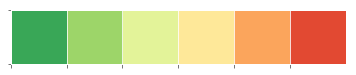

In [54]:
# create a color palette - %%capture will suppreess cell out put
sns.palplot(sns.palettes.color_palette('RdYlGn_r'))

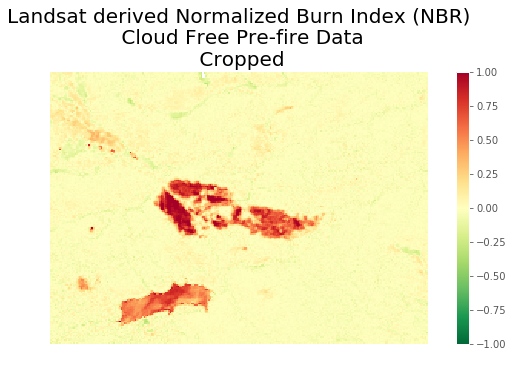

In [55]:
fig, ax = plt.subplots(figsize = (10,5))
dnbr_img = ax.imshow(dNBR_landsat, cmap=plt.cm.get_cmap('RdYlGn_r', 500), vmin = -1, vmax=1)
plt.colorbar(dnbr_img)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Cloud Free Pre-fire Data\n Cropped")
ax.set_axis_off()

SEVERITY LEVEL	 	dNBR RANGE
Enhanced Regrowth	 	< -.1
Unburned	 	-.1 to +.1
Low Severity	 	+.1 to +.27
Moderate Severity	 	+.27 to +.66
High Severity	 	> .66

In [56]:
# Define bins that we want, and then classify the data
nbr_class_bins = [-.1, .1, .27, .66, np.inf]
dNBR_landsat_cl = np.digitize(dNBR_landsat, nbr_class_bins)
dNBR_landsat_cl.max()

4

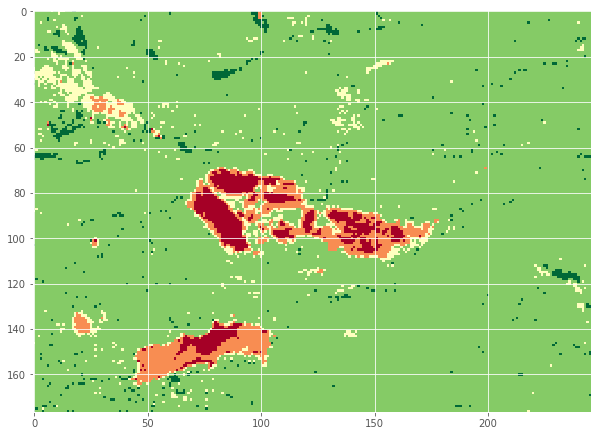

In [57]:
from matplotlib.colors import ListedColormap, BoundaryNorm

xlabels = ["short trees", "medium trees", "tall trees"]

#cmap=plt.cm.get_cmap('RdYlGn_r', 5)

#cmap = ListedColormap(['w'] + colors)
#norm = BoundaryNorm(class_bins, len(colors))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(dNBR_landsat_cl, cmap=plt.cm.get_cmap('RdYlGn_r', 5));
#ax.legend(handles=legend_patches)

SEVERITY LEVEL	 	dNBR RANGE
Enhanced Regrowth	 	< -.1
Unburned	 	-.1 to +.1
Low Severity	 	+.1 to +.27
Moderate Severity	 	+.27 to +.66
High Severity	 	> .66

In [58]:
# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 1, 2, 3, 4], 5)

NameError: name 'colors' is not defined

In [ ]:


#boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
#                  for ii in range(1, len(norm.boundaries))]
nbr_classes = ['Enhanced Regrowth', 'Unburned', 'Low Severity', 'Moderate Severity', 'High Severity']


fig, ax = plt.subplots(figsize = (10,5))
dnbr_img_cl = ax.imshow(dNBR_landsat_cl, cmap=plt.cm.get_cmap('RdYlGn_r', 5))

#plt.colorbar(dnbr_img_cl)
ax.set(title="Landsat derived Normalized Burn Index (NBR)\n Cloud Free Pre-fire Data\n Cropped")

#divider = make_axes_locatable(ax)

#cax = divider.append_axes("right", size="3%", pad=0.15)
cbar = plt.colorbar(dnbr_img_cl)

# i don't understand how to get the ticks in the right place on a classified plot

cbar.set_ticks([.5,1.5,2.5,3.5,4.5, 5])
cbar.set_ticklabels(nbr_classes)
ax.set_axis_off();